# MCT Assignment 2 - Question 1 - Training a neural network to reproduce a double Exclusive Or (XOR) behaviour

## Truth Table For $A \oplus B \oplus C$
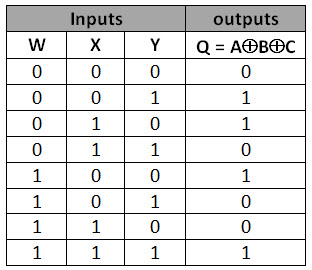

## Proposed Feed Forward Neural Network
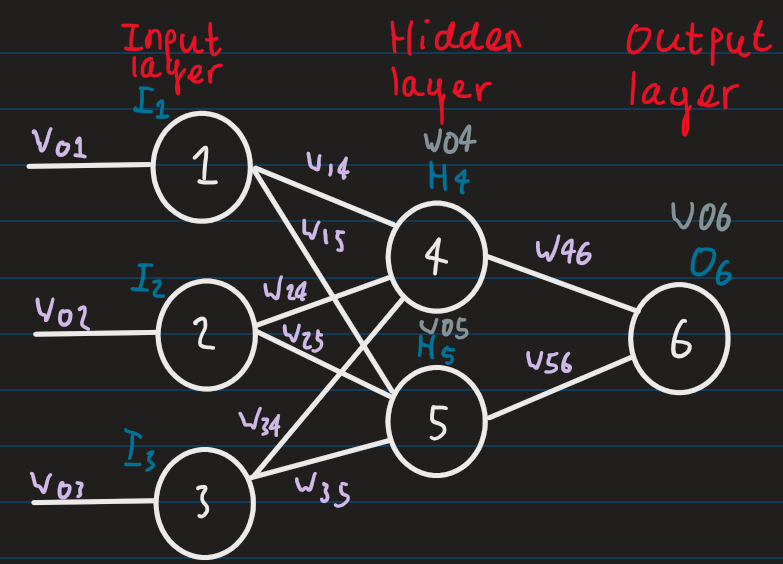

It is known that with continuous activitation functions for the neurons, parity problems can be solved with $n_{hidden}=n_{in}-1$ (also have been told so in the assignment)

## Imports
Numpy for maths

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Defining initial values and constants
### Weighting
$w = \left \{ w_{i, j} \right \}$

Where if $i = 0$ defines an implicit weighting for a node

$w_{0,1}, w_{0, 2}, w_{0, 3}$ are all equal to 1 as each input is equal in importance for the XOR problem

Weights are defined as random values between $\left [ -0.1, 0.1 \right ]$

Weight array is list of weights like so $\left [ w_{0,4}, w_{0,5}, w_{0,6}, w_{1,4}, w_{1,5}, w_{2,4}, w_{2,5}, w_{3,4}, w_{3,5}, w_{4,6}, w_{5,6}\right ]$

### Truth table
Truth table is determined in the TT variable, these are our input output functions.

Characterised by a set of input-output patterns, represented mathematically as $D_t=\left \{ x_p, t_p \right \}$ where $x_p$ and $t_p$ are input patterns and target output patterns respectively.

### Metropolis Parameters
Delta is our stepsize

Inverse temperature is beta

In [2]:
rng = np.random.default_rng() # Random number generator
k = 1.0
delta = 0.05 # stepsize
beta_0 = 5 #initial inverse temperature
beta = beta_0

n_out = 1
n_patts = 8

TT = [
    [0, 0, 0, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 1],
    [0, 1, 1, 0],
    [1, 0, 0, 1],
    [1, 0, 1, 0],
    [1, 1, 0, 0],
    [1, 1, 1, 1]
]

## Defining our functions
### Energy (error) function
We first define an energy function - the output of which we hope to minimise - this can be defined multiple ways, two are defined below.
1. 
> $E(w)=(t_p-out_p)^2$ 
(as defined in neural network lecture notes) (Eq 1)
2. 
> $E(w)=\frac{\sum_p\left | out_p - t_p \right |^2}{n_{out}n_{patts}}$ 
(where $n_{out}$ and $n_{patts}$ are number of output nodes and patterns(number of rows in truth table)) (Eq 2)

It is important to note that the Metropolis algorithm is not dependent on the energy (error) function, thus any form of error function could be implemented.

For this implementation we go for the second function for error calculations.

### Introducing Boltzmann-Gibbs probability Distribution
A neural network with weights and patterns can be treated as a statistical system.

We introduce dynamics by demanding our system obeys Boltzmann-Gibbs probability dimension
> $P(\left \{ w_{i, j} \right \})=\frac{e^{-\beta E(w)}}{Z}$ (Eq 3)

Where the partition function, $Z$, is given by:
> $Z=\sum_{w_{i,j}}e^{-\beta E(w)}$ (Eq 4)

For a system obeying eq(3), as $\beta \rightarrow \infty$ energy approaches a minimum

### Calculating node input and output
To work out input for each hidden node:
> $X_i=w_{0i}+w_{1i}I_1+w_{2i}I_2+w_{3i}I_3$ for $I=4,5$

Output of each node in the hidden layer is given by:
> $H_h=\frac{1}{1+e^{-k\cdot X_h}}$ for $h=5, 6, 7$

Inputs to the output nodes given by:
> $X = w_{06} + w_{46}H_4 + w_{56}H_5$

Output node given by:
> $O=\frac{1}{1+e^{-k\cdot X}}$

In [3]:
def calcNodeOutput(x):
    return 1.0 / (1.0 + np.exp(-k * x))

def calcError(targets, outputs):
    sum = 0
    
    for i in range(len(targets)):
        sum += (outputs[i] - targets[i])**2
           
    return sum/(n_out * n_patts)

def network_test():
    correct = 0; err = 0.0
    
    targets=np.zeros(len(TT))
    outputs=np.zeros(len(TT))
    
    for i in range(len(TT)):
        i1=TT[i][0]; i2=TT[i][1]; i3=TT[i][2]
        h4=calcNodeOutput(w[0] + w[3]*i1 + w[5]*i2 + w[7]*i3)
        h5=calcNodeOutput(w[1] + w[4]*i1 + w[6]*i2 + w[8]*i3)
        o6=calcNodeOutput(w[2] + w[9]*h4 + w[10]*h5)
        targets[i] = TT[i][3]
        outputs[i] = o6
        if(int(round(o6)) == TT[i][3]):
            correct+=1
            
    err = calcError(targets, outputs)
    return correct, err

def beta_warming(error):    
    #return beta + np.exp(beta_0 / error)
    return np.exp(beta_0 / error)

def beta_cooling(error):
    print("beta cooling")
    
    cooled_value = np.log(beta_0 / error)
    return cooled_value

## Method (Metropolis algorithm)
Metropolis algorithm generates the next configuration by using the former one in the chain. Therefore, there is always a small correlation between subsequent configurations.

We can avoid this by using an N-hit Metropolis algorithm by measuring observables on every Nth interation.

The configuration is generated in the Basic Metropolis Update Step (BMUS).

The overall problem is solved in the Total Update Algorithm (TUA).

### Total-Update Algorithm (TUA):
1. Set stepsize $\delta$ (learning rate) and inverse temperature $\beta$
2. Initialise network by generating weights uniformly in a range, in this case $\left [ -0.1, 0.1 \right ]$
3. Perform 10 BMUS as explained below and measure observables on the Nth iteration (measuring energy of the network)
4. Check for the last 30 TUA iterations that the energy of the system is getting smaller
> if it is then cool the system by increasing beta (heating beta) such that it tends to infinity as the error of the system reaches a minimum - meaning less statistical fluctuations occur
> if it isn't then heat the system by decreasing beta (cooling beta) - allowing more random statistical fluctuations to occur
5. If cooling has occurred check that it has worked, if it hasn't reset the weights of the system - this is because the energy has reached a minimum that doesn't provide the correct answer
6. Repeat steps 3-5 for selected number of TUA iterations

### Basic Metropolis Update Step (BMUS)
1. Loop over all weights $w_{i, j}$ in network and for each do the following
2. Draw random number uniformly between $-1.0$ and $1.0$ such that 
> $r \in U (-1, 1)$
3. Propose change in given weight by
> $w_{i, j} = w_{i, j} + r \cdot\delta$
4. Compute new energy $E'$ of network, and compare with current energy $E_0$
5. If $\Delta E = E' - E_0 < 0$ accept change ($E_0=E'$), else draw number $p\in U(0, 1)$ and accept change if $p < e^{-\beta \Delta E}$ ($E_0=E'$) else reject proposed change and keep old value ($E_0 = E_0$)

### Observations of algorithm
This means the algorithm will always accept weight-changes that decrease energy, but also accepts some weight changes that increase the energy.

The reasoning for this is that this will introduce statistical fluctuations into the system.

In [4]:
def BMUS(error_0):
    for i in range(len(w)):
        old_weight = w[i]
        r = 2.0 * rng.random(size=1)[0] - 1.0
        
        w[i] = w[i] + r * delta
        new_correct, new_error = network_test()
        
        delta_E = new_error - error_0
        
        if(delta_E > 0): # if error has gotten larger
            p = rng.random(size=1)[0]
            if(p > np.exp(-beta * delta_E)): # if statistical fluctuation is not allowed
                w[i] = old_weight

# initialise beta and weights
beta = beta_0
w = (2.0 * rng.random(size=11) - 1.0)
print("inital weights are: ", w)

# initialise variables needed for looping/outputs
n_correct = 0
N_BMU_iterations = 10
tua_n = 2000
bmus_n = 0
n_cooling = 0
n_actual_cooling = 0
n_reset = 0
correct_found = -1
errors = np.zeros(tua_n)
iteration = np.linspace(1, tua_n, tua_n)
n_since_last_cool = -1

while(n_correct != 8): # TODO implement this correctly

    for i in range(tua_n):

        n_correct, error_0 = network_test()
        errors[i] = error_0

        # record when correct value was found
        if(n_correct == 8 and correct_found == -1):
             correct_found = i+1

        # for first 200 iterations don't allow beta cooling, only warm beta
        if(i < 200):
            # warm beta value
            beta = beta_warming(errors[i])
        else:
            # calculate the mean and variation for the last 30 error values
            prev_30_errors = errors[i-29:i]
            mean = np.mean(prev_30_errors)
            var = np.var(prev_30_errors)

            # if there has recently been cooling, add one to the counter for how many iterations
            # it has been since last cool
            if(n_since_last_cool > -1):
                        n_since_last_cool += 1

            # if error value hasn't changed enough to go above the threshold var/mean value, we haven't already got the correct answer
            # we haven't already cooled for these weight values and there hasn't recently been a cooling from last set of weights
            # then start cooling
            if(var/mean < 0.000000001 and n_correct != 8 and n_cooling < 1 and (n_since_last_cool > 250 or n_since_last_cool == -1)): #0.000001%
                n_cooling += 1
                n_actual_cooling += 1

                beta = beta_cooling(errors[i])
                n_since_last_cool = 0

            # if there's been cooling and it hasn't worked then reset weights and beta value
            elif(var/mean < 0.00000001 and n_since_last_cool > 200 and n_correct != 8 and n_cooling == 1):
                print("Resetting weights")
                w = (2.0 * rng.random(size=11) - 1.0)
                beta=beta_0
                n_cooling = 0
                n_reset += 1

            # if cooling has ended/not happened then just warm value as per norm
            elif(n_since_last_cool > 100 or n_since_last_cool == -1):
                #delta_E = np.absolute(errors[i] - errors[i-1])
                beta = beta_warming(errors[i])
            # if cooling has recently started continue cooling beta value
            elif(n_since_last_cool < 50):
                #delta_E = np.absolute(errors[i] - errors[i-1])
                beta = beta_cooling(errors[i])

        # for number of BMU iterations complete a BMUS without checking error value
        for j in range(N_BMU_iterations):
            BMUS(error_0)
            bmus_n += 1

        print("Iteration", i+1)
        print(network_test()) 
        print("Inverse Temperature - ", beta)


print("Initial Neural Network completed")
#print("There were", tua_n, "completed TUA iterations")
#print("There were", bmus_n, "completed BMUS iterations")
print("Beta was cooled", n_actual_cooling, "times")
if(correct_found == -1):
    print("The correct truth table was not reproduced")
else:
    print("The correct truth table was found in", correct_found, "iterations")
print("Final error was", errors[-1])
print("The weights and beta was reset", n_reset, "times")

inital weights are:  [-0.01528315  0.28508365 -0.0869762   0.37749438  0.20535618  0.09748673
 -0.72252678 -0.13884949  0.54422853 -0.52531386  0.18560961]
Iteration 1
(4, 0.2512375966535033)
Inverse Temperature -  345122056.3400591
Iteration 2
(4, 0.25017410324873846)
Inverse Temperature -  439645808.44925356
Iteration 3
(4, 0.25013564716252956)
Inverse Temperature -  478459168.6166764
Iteration 4
(4, 0.250088660814167)
Inverse Temperature -  479931580.87056214
Iteration 5
(3, 0.25007508268629186)
Inverse Temperature -  481737370.6812117
Iteration 6
(5, 0.24998129972497207)
Inverse Temperature -  482260599.38122743
Iteration 7
(4, 0.24995667377220482)
Inverse Temperature -  485891610.78471047
Iteration 8
(4, 0.24994235411598936)
Inverse Temperature -  486850035.8470298
Iteration 9
(4, 0.2499361849129068)
Inverse Temperature -  487408303.02041024
Iteration 10
(5, 0.24992393414441402)
Inverse Temperature -  487649033.02748245
Iteration 11
(4, 0.249909821034663)
Inverse Temperature -  48

Iteration 116
(6, 0.17935934738493603)
Inverse Temperature -  1155174053693.002
Iteration 117
(6, 0.17920394976478327)
Inverse Temperature -  1278868810696.0662
Iteration 118
(6, 0.1785623449214438)
Inverse Temperature -  1310160470027.4312
Iteration 119
(6, 0.17781969686389767)
Inverse Temperature -  1448318564458.5417
Iteration 120
(6, 0.17762282953183933)
Inverse Temperature -  1627994219680.8372
Iteration 121
(6, 0.17678260197081347)
Inverse Temperature -  1679529281925.1104
Iteration 122
(6, 0.17661491694743464)
Inverse Temperature -  1919961426055.5076
Iteration 123
(6, 0.1753732626397786)
Inverse Temperature -  1972217171212.3738
Iteration 124
(6, 0.1752272145214843)
Inverse Temperature -  2409926676147.691
Iteration 125
(6, 0.17462482726817843)
Inverse Temperature -  2467879572447.106
Iteration 126
(6, 0.17441731824906065)
Inverse Temperature -  2723156661608.4795
Iteration 127
(6, 0.17337938690816118)
Inverse Temperature -  2817519758345.493
Iteration 128
(6, 0.172563553886777

Iteration 223
(5, 0.12962658518450676)
Inverse Temperature -  5.642069827742615e+16
Iteration 224
(5, 0.12956624485463958)
Inverse Temperature -  5.6461448371211784e+16
Iteration 225
(6, 0.1295401369184684)
Inverse Temperature -  5.748485992887128e+16
Iteration 226
(5, 0.12947449432001099)
Inverse Temperature -  5.79336980979247e+16
Iteration 227
(6, 0.12946997908784724)
Inverse Temperature -  5.907856424822302e+16
Iteration 228
(6, 0.12934130452878806)
Inverse Temperature -  5.915818370378484e+16
Iteration 229
(5, 0.1290634577718807)
Inverse Temperature -  6.147526194245618e+16
Iteration 230
(5, 0.1290439904462576)
Inverse Temperature -  6.6810229696474264e+16
Iteration 231
(5, 0.1288844045964733)
Inverse Temperature -  6.720183438384845e+16
Iteration 232
(5, 0.128810922765487)
Inverse Temperature -  7.050451758806503e+16
Iteration 233
(5, 0.12866587573865404)
Inverse Temperature -  7.208223188359043e+16
Iteration 234
(5, 0.12862885059343832)
Inverse Temperature -  7.530647426990682e+

Iteration 323
(6, 0.12541482166870072)
Inverse Temperature -  2.0537904599092422e+17
Iteration 324
(6, 0.1253987797901716)
Inverse Temperature -  2.0621508606798058e+17
Iteration 325
(6, 0.12539504432715315)
Inverse Temperature -  2.0726950074028493e+17
Iteration 326
(6, 0.1253926671752884)
Inverse Temperature -  2.075158402736845e+17
Iteration 327
(5, 0.12539106591178065)
Inverse Temperature -  2.0767276443904758e+17
Iteration 328
(6, 0.12538645464150278)
Inverse Temperature -  2.0777853972251536e+17
Iteration 329
(6, 0.12538615660786384)
Inverse Temperature -  2.0808346437262256e+17
Iteration 330
(5, 0.12538493798039524)
Inverse Temperature -  2.081031882924599e+17
Iteration 331
(5, 0.12538473292618743)
Inverse Temperature -  2.081838577066683e+17
Iteration 332
(6, 0.12537168935499085)
Inverse Temperature -  2.0819743489601085e+17
Iteration 333
(5, 0.12536658481419213)
Inverse Temperature -  2.0906299845991648e+17
Iteration 334
(6, 0.1253635544154639)
Inverse Temperature -  2.0940276

Iteration 429
(6, 0.13508592500055583)
Inverse Temperature -  3.6490486641245736
beta cooling
Iteration 430
(6, 0.13518130633123945)
Inverse Temperature -  3.611282133960643
beta cooling
Iteration 431
(6, 0.1325622058219396)
Inverse Temperature -  3.6105763041478793
beta cooling
Iteration 432
(6, 0.13108830290815773)
Inverse Temperature -  3.6301411782587993
beta cooling
Iteration 433
(6, 0.12931770129608613)
Inverse Temperature -  3.641322027295677
beta cooling
Iteration 434
(6, 0.12826003215618176)
Inverse Temperature -  3.654921014033365
beta cooling
Iteration 435
(6, 0.1277697374789376)
Inverse Temperature -  3.6631334869846386
beta cooling
Iteration 436
(6, 0.12840742532382782)
Inverse Temperature -  3.6669634734528436
beta cooling
Iteration 437
(6, 0.12772250680894712)
Inverse Temperature -  3.661984972207618
beta cooling
Iteration 438
(6, 0.12883757629388104)
Inverse Temperature -  3.667333196382478
beta cooling
Iteration 439
(6, 0.12975060575046937)
Inverse Temperature -  3.658

Iteration 531
(6, 0.12512596787765587)
Inverse Temperature -  2.2600186246233725e+17
Iteration 532
(6, 0.12511882244267877)
Inverse Temperature -  2.260948191813969e+17
Iteration 533
(6, 0.12511026239803155)
Inverse Temperature -  2.2661137210927606e+17
Iteration 534
(6, 0.12509971263532949)
Inverse Temperature -  2.2723182099764195e+17
Iteration 535
(6, 0.1250945774338168)
Inverse Temperature -  2.2799894336434714e+17
Iteration 536
(6, 0.12509333091351205)
Inverse Temperature -  2.2837333131062845e+17
Iteration 537
(6, 0.12508993184607947)
Inverse Temperature -  2.2846430767915187e+17
Iteration 538
(6, 0.125081682531337)
Inverse Temperature -  2.2871257954037597e+17
Iteration 539
(6, 0.12507904944986878)
Inverse Temperature -  2.293162979518237e+17
Iteration 540
(6, 0.12507171004040107)
Inverse Temperature -  2.2950934967353907e+17
Iteration 541
(6, 0.12507165939386528)
Inverse Temperature -  2.3004836029599165e+17
Iteration 542
(6, 0.12506179593475633)
Inverse Temperature -  2.300520

(3, 0.24938681242177102)
Inverse Temperature -  507505867.40794647
Iteration 630
(4, 0.24924982980215002)
Inverse Temperature -  509619854.1774068
Iteration 631
(4, 0.2492190201326365)
Inverse Temperature -  515266210.9430581
Iteration 632
(4, 0.24910192160760417)
Inverse Temperature -  516545625.4680048
Iteration 633
(6, 0.24883026707287817)
Inverse Temperature -  521440272.8029888
Iteration 634
(6, 0.24881932895920322)
Inverse Temperature -  532992835.65933806
Iteration 635
(3, 0.24840002506951592)
Inverse Temperature -  533463854.53969395
Iteration 636
(3, 0.2483686009664703)
Inverse Temperature -  551869655.5840777
Iteration 637
(3, 0.2483285352033932)
Inverse Temperature -  553276915.1785233
Iteration 638
(5, 0.24759867928950713)
Inverse Temperature -  555076897.1160225
Iteration 639
(4, 0.24691829612034472)
Inverse Temperature -  589018872.0011963
Iteration 640
(3, 0.2465189464894595)
Inverse Temperature -  622723555.3023807
Iteration 641
(3, 0.24643348084187358)
Inverse Temperat

Iteration 735
(6, 0.1570273633087058)
Inverse Temperature -  41144522912074.22
Iteration 736
(6, 0.15670375113255813)
Inverse Temperature -  67394473379259.445
Iteration 737
(6, 0.15530919611148397)
Inverse Temperature -  71975064667115.25
Iteration 738
(6, 0.15372280092798352)
Inverse Temperature -  95853662742012.47
Iteration 739
(6, 0.15312602853617727)
Inverse Temperature -  133627769920795.66
Iteration 740
(6, 0.15162422720708033)
Inverse Temperature -  151687241658790.62
Iteration 741
(6, 0.1515976866105353)
Inverse Temperature -  209608035389481.25
Iteration 742
(6, 0.15142587855360978)
Inverse Temperature -  210821652479561.25
Iteration 743
(6, 0.150304719051687)
Inverse Temperature -  218860381273755.4
Iteration 744
(6, 0.1495297794428234)
Inverse Temperature -  279984474870214.53
Iteration 745
(6, 0.1493669426764131)
Inverse Temperature -  332664432310230.25
Iteration 746
(6, 0.14870795918227456)
Inverse Temperature -  345014988096933.1
Iteration 747
(6, 0.1466124352650828)
I

Iteration 844
(8, 0.07007759170126891)
Inverse Temperature -  5.200983798239005e+30
Iteration 845
(8, 0.06988273646262112)
Inverse Temperature -  9.698110746964667e+30
Iteration 846
(8, 0.06956814074330259)
Inverse Temperature -  1.1832808964374738e+31
Iteration 847
(8, 0.06952206190325042)
Inverse Temperature -  1.6353254355403695e+31
Iteration 848
(8, 0.06697145649645768)
Inverse Temperature -  1.7151116496404278e+31
Iteration 849
(8, 0.06590684771216429)
Inverse Temperature -  2.6536842712851744e+32
Iteration 850
(8, 0.0658086769161145)
Inverse Temperature -  8.863378577821786e+32
Iteration 851
(8, 0.0654423689407805)
Inverse Temperature -  9.925427750676079e+32
Iteration 852
(8, 0.06483237161866573)
Inverse Temperature -  1.5186079526856218e+33
Iteration 853
(8, 0.06433221941800638)
Inverse Temperature -  3.1163378712100786e+33
Iteration 854
(8, 0.06307285070899417)
Inverse Temperature -  5.6759895262826e+33
Iteration 855
(8, 0.06206604327648137)
Inverse Temperature -  2.6791981863

Iteration 954
(8, 0.026974498993326303)
Inverse Temperature -  1.243701899126183e+80
Iteration 955
(8, 0.02665190217847285)
Inverse Temperature -  3.1690983628577933e+80
Iteration 956
(8, 0.026550760710542156)
Inverse Temperature -  2.9876220942712076e+81
Iteration 957
(8, 0.02644812207608237)
Inverse Temperature -  6.105126958031915e+81
Iteration 958
(8, 0.02600318045654912)
Inverse Temperature -  1.267899400017643e+82
Iteration 959
(8, 0.025750889076619245)
Inverse Temperature -  3.220731087274189e+83
Iteration 960
(8, 0.025192032666095616)
Inverse Temperature -  2.1189175775196977e+84
Iteration 961
(8, 0.024954571483613595)
Inverse Temperature -  1.5732306057366936e+86
Iteration 962
(8, 0.02493204739714602)
Inverse Temperature -  1.0399645675047764e+87
Iteration 963
(8, 0.02485419709669807)
Inverse Temperature -  1.2463251951574006e+87
Iteration 964
(8, 0.024773156822656295)
Inverse Temperature -  2.3358194193540825e+87
Iteration 965
(8, 0.024616391774316623)
Inverse Temperature -  

Iteration 1054
(8, 0.009633521966636931)
Inverse Temperature -  5.155965776126106e+214
Iteration 1055
(8, 0.009433009130089832)
Inverse Temperature -  2.558274053432878e+225
Iteration 1056
(8, 0.009385007235274499)
Inverse Temperature -  1.5824607836232046e+230
Iteration 1057
(8, 0.009361313681637555)
Inverse Temperature -  2.380911508997451e+231
Iteration 1058
(8, 0.008849123522056527)
Inverse Temperature -  9.169792108506489e+231
Iteration 1059
(8, 0.008848041204691638)
Inverse Temperature -  2.4457756447111583e+245
Iteration 1060
(8, 0.008774874108198064)
Inverse Temperature -  2.6207960131504554e+245
Iteration 1061
(8, 0.008589309369273464)
Inverse Temperature -  2.916040416494629e+247
Iteration 1062
(8, 0.008497295091796123)
Inverse Temperature -  6.4723258360403235e+252
Iteration 1063
(8, 0.008481424318175198)
Inverse Temperature -  3.5372368482378073e+255
Iteration 1064
(8, 0.008417051540583536)
Inverse Temperature -  1.0637922383819344e+256
Iteration 1065
(8, 0.0083108462731006

<ipython-input-3-9c694ee56db4>:33: RuntimeWarning: overflow encountered in exp
  return np.exp(beta_0 / error)


 1091
(8, 0.006403901094307191)
Inverse Temperature -  inf
Iteration 1092
(8, 0.006285500116106896)
Inverse Temperature -  inf
Iteration 1093
(8, 0.006225347203163759)
Inverse Temperature -  inf
Iteration 1094
(8, 0.0061949193366237386)
Inverse Temperature -  inf
Iteration 1095
(8, 0.006177897630153417)
Inverse Temperature -  inf
Iteration 1096
(8, 0.006093291564184013)
Inverse Temperature -  inf
Iteration 1097
(8, 0.006059488699660631)
Inverse Temperature -  inf
Iteration 1098
(8, 0.006005654783390978)
Inverse Temperature -  inf
Iteration 1099
(8, 0.005947063870002649)
Inverse Temperature -  inf
Iteration 1100
(8, 0.005917488586029183)
Inverse Temperature -  inf
Iteration 1101
(8, 0.005884118161140803)
Inverse Temperature -  inf
Iteration 1102
(8, 0.005809343404929044)
Inverse Temperature -  inf
Iteration 1103
(8, 0.00568814420274221)
Inverse Temperature -  inf
Iteration 1104
(8, 0.005587064200554849)
Inverse Temperature -  inf
Iteration 1105
(8, 0.0055141402606622095)
Inverse Tempera

Iteration 1211
(8, 0.0014969216156408948)
Inverse Temperature -  inf
Iteration 1212
(8, 0.00147795838615937)
Inverse Temperature -  inf
Iteration 1213
(8, 0.001473545492875274)
Inverse Temperature -  inf
Iteration 1214
(8, 0.001472735394035547)
Inverse Temperature -  inf
Iteration 1215
(8, 0.0014277302315292457)
Inverse Temperature -  inf
Iteration 1216
(8, 0.0014084424083735821)
Inverse Temperature -  inf
Iteration 1217
(8, 0.00136063438854794)
Inverse Temperature -  inf
Iteration 1218
(8, 0.0013495037175283704)
Inverse Temperature -  inf
Iteration 1219
(8, 0.0013435792051938677)
Inverse Temperature -  inf
Iteration 1220
(8, 0.0013118600628263862)
Inverse Temperature -  inf
Iteration 1221
(8, 0.0012718303315683416)
Inverse Temperature -  inf
Iteration 1222
(8, 0.001256970392972531)
Inverse Temperature -  inf
Iteration 1223
(8, 0.0012397583135978114)
Inverse Temperature -  inf
Iteration 1224
(8, 0.0012345081302745074)
Inverse Temperature -  inf
Iteration 1225
(8, 0.0011922092425148865)

Iteration 1341
(8, 0.00029884481173804634)
Inverse Temperature -  inf
Iteration 1342
(8, 0.00029830484459926097)
Inverse Temperature -  inf
Iteration 1343
(8, 0.0002982366332757082)
Inverse Temperature -  inf
Iteration 1344
(8, 0.0002975891925365338)
Inverse Temperature -  inf
Iteration 1345
(8, 0.0002946092828127843)
Inverse Temperature -  inf
Iteration 1346
(8, 0.0002938254432035707)
Inverse Temperature -  inf
Iteration 1347
(8, 0.0002903144207209364)
Inverse Temperature -  inf
Iteration 1348
(8, 0.0002824020208834258)
Inverse Temperature -  inf
Iteration 1349
(8, 0.0002794294188157201)
Inverse Temperature -  inf
Iteration 1350
(8, 0.00027846683026088863)
Inverse Temperature -  inf
Iteration 1351
(8, 0.0002759997688347356)
Inverse Temperature -  inf
Iteration 1352
(8, 0.000273798281283436)
Inverse Temperature -  inf
Iteration 1353
(8, 0.00027320702483421766)
Inverse Temperature -  inf
Iteration 1354
(8, 0.0002731458505469329)
Inverse Temperature -  inf
Iteration 1355
(8, 0.0002723543

Iteration 1460
(8, 7.801560206425425e-05)
Inverse Temperature -  inf
Iteration 1461
(8, 7.77980360446867e-05)
Inverse Temperature -  inf
Iteration 1462
(8, 7.77528680266129e-05)
Inverse Temperature -  inf
Iteration 1463
(8, 7.588388544769203e-05)
Inverse Temperature -  inf
Iteration 1464
(8, 7.383110319726103e-05)
Inverse Temperature -  inf
Iteration 1465
(8, 7.197244941961301e-05)
Inverse Temperature -  inf
Iteration 1466
(8, 6.99163739921711e-05)
Inverse Temperature -  inf
Iteration 1467
(8, 6.928632343080507e-05)
Inverse Temperature -  inf
Iteration 1468
(8, 6.917838309593081e-05)
Inverse Temperature -  inf
Iteration 1469
(8, 6.743364372141854e-05)
Inverse Temperature -  inf
Iteration 1470
(8, 6.643929430573573e-05)
Inverse Temperature -  inf
Iteration 1471
(8, 6.504004600466048e-05)
Inverse Temperature -  inf
Iteration 1472
(8, 6.476818175877277e-05)
Inverse Temperature -  inf
Iteration 1473
(8, 6.211704088614752e-05)
Inverse Temperature -  inf
Iteration 1474
(8, 6.176133248307118e

Iteration 1589
(8, 1.446786266301646e-05)
Inverse Temperature -  inf
Iteration 1590
(8, 1.4446445142306307e-05)
Inverse Temperature -  inf
Iteration 1591
(8, 1.437520117419661e-05)
Inverse Temperature -  inf
Iteration 1592
(8, 1.4213860340760132e-05)
Inverse Temperature -  inf
Iteration 1593
(8, 1.4122068447481505e-05)
Inverse Temperature -  inf
Iteration 1594
(8, 1.3980229287992239e-05)
Inverse Temperature -  inf
Iteration 1595
(8, 1.3976141521803336e-05)
Inverse Temperature -  inf
Iteration 1596
(8, 1.3971838976035907e-05)
Inverse Temperature -  inf
Iteration 1597
(8, 1.3807699661411464e-05)
Inverse Temperature -  inf
Iteration 1598
(8, 1.3663016514132692e-05)
Inverse Temperature -  inf
Iteration 1599
(8, 1.3608215124538276e-05)
Inverse Temperature -  inf
Iteration 1600
(8, 1.3297152607583918e-05)
Inverse Temperature -  inf
Iteration 1601
(8, 1.310067545644616e-05)
Inverse Temperature -  inf
Iteration 1602
(8, 1.2889478646819233e-05)
Inverse Temperature -  inf
Iteration 1603
(8, 1.23

Iteration 1711
(8, 3.857367591519129e-06)
Inverse Temperature -  inf
Iteration 1712
(8, 3.7943434038402646e-06)
Inverse Temperature -  inf
Iteration 1713
(8, 3.741358514262966e-06)
Inverse Temperature -  inf
Iteration 1714
(8, 3.6549485079046657e-06)
Inverse Temperature -  inf
Iteration 1715
(8, 3.6476813111762344e-06)
Inverse Temperature -  inf
Iteration 1716
(8, 3.619022680166464e-06)
Inverse Temperature -  inf
Iteration 1717
(8, 3.5338138228767442e-06)
Inverse Temperature -  inf
Iteration 1718
(8, 3.497335085412276e-06)
Inverse Temperature -  inf
Iteration 1719
(8, 3.488096158414406e-06)
Inverse Temperature -  inf
Iteration 1720
(8, 3.466156851995848e-06)
Inverse Temperature -  inf
Iteration 1721
(8, 3.4504835244875447e-06)
Inverse Temperature -  inf
Iteration 1722
(8, 3.445907654068177e-06)
Inverse Temperature -  inf
Iteration 1723
(8, 3.431152609583275e-06)
Inverse Temperature -  inf
Iteration 1724
(8, 3.4194209553487456e-06)
Inverse Temperature -  inf
Iteration 1725
(8, 3.3945896

Iteration 1842
(8, 8.797823710925906e-07)
Inverse Temperature -  inf
Iteration 1843
(8, 8.702424313876057e-07)
Inverse Temperature -  inf
Iteration 1844
(8, 8.691680858765157e-07)
Inverse Temperature -  inf
Iteration 1845
(8, 8.612680493509673e-07)
Inverse Temperature -  inf
Iteration 1846
(8, 8.5658638387578e-07)
Inverse Temperature -  inf
Iteration 1847
(8, 8.400320154474306e-07)
Inverse Temperature -  inf
Iteration 1848
(8, 8.26514619588876e-07)
Inverse Temperature -  inf
Iteration 1849
(8, 8.152669816399998e-07)
Inverse Temperature -  inf
Iteration 1850
(8, 8.136180051597614e-07)
Inverse Temperature -  inf
Iteration 1851
(8, 8.110160717311892e-07)
Inverse Temperature -  inf
Iteration 1852
(8, 7.980964248209274e-07)
Inverse Temperature -  inf
Iteration 1853
(8, 7.966276737579742e-07)
Inverse Temperature -  inf
Iteration 1854
(8, 7.91518749240177e-07)
Inverse Temperature -  inf
Iteration 1855
(8, 7.893037363478874e-07)
Inverse Temperature -  inf
Iteration 1856
(8, 7.807617462029544e-

Iteration 1970
(8, 2.0209414203250586e-07)
Inverse Temperature -  inf
Iteration 1971
(8, 1.951277759619396e-07)
Inverse Temperature -  inf
Iteration 1972
(8, 1.899534320285786e-07)
Inverse Temperature -  inf
Iteration 1973
(8, 1.8803647459815752e-07)
Inverse Temperature -  inf
Iteration 1974
(8, 1.8461154328947094e-07)
Inverse Temperature -  inf
Iteration 1975
(8, 1.816397401399531e-07)
Inverse Temperature -  inf
Iteration 1976
(8, 1.774355858717624e-07)
Inverse Temperature -  inf
Iteration 1977
(8, 1.7661958483881125e-07)
Inverse Temperature -  inf
Iteration 1978
(8, 1.726667639342664e-07)
Inverse Temperature -  inf
Iteration 1979
(8, 1.7136233454856373e-07)
Inverse Temperature -  inf
Iteration 1980
(8, 1.6630629052025865e-07)
Inverse Temperature -  inf
Iteration 1981
(8, 1.6587817161496446e-07)
Inverse Temperature -  inf
Iteration 1982
(8, 1.6573277554712518e-07)
Inverse Temperature -  inf
Iteration 1983
(8, 1.6317853728244554e-07)
Inverse Temperature -  inf
Iteration 1984
(8, 1.6010

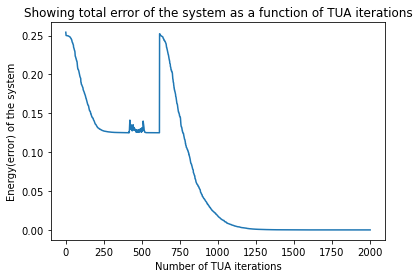

In [5]:
plt.plot(iteration, errors)
plt.xlabel("Number of TUA iterations")
plt.ylabel("Energy(error) of the system")
plt.title("Showing total error of the system as a function of TUA iterations")
plt.show()

In [6]:
# final outputs
print ("  X1   X2   X3   |  target   actual ")
for i in range(len(TT)):
    i1=TT[i][0]; i2=TT[i][1]; i3=TT[i][2]
    h4=calcNodeOutput(w[0] + w[3]*i1 + w[5]*i2 + w[7]*i3)
    h5=calcNodeOutput(w[1] + w[4]*i1 + w[6]*i2 + w[8]*i3)
    o6=calcNodeOutput(w[2] + w[9]*h4 + w[10]*h5)
    
    print(" ",TT[i][0], "  ", TT[i][1],"  ", TT[i][2], "   |   " , TT[i][3], "    " , o6)

  X1   X2   X3   |  target   actual 
  0    0    0    |    0      0.0003427461363565367
  0    0    1    |    1      0.9997579273286715
  0    1    0    |    1      0.9996608230400574
  0    1    1    |    0      0.0004419834690207513
  1    0    0    |    1      0.9995245096679767
  1    0    1    |    0      0.00032028882506324343
  1    1    0    |    0      0.00022836588795659604
  1    1    1    |    1      0.9996331970912022
